# Amaon Product Review Sentiment Analysis
Lab Assignment Seven: Recurrent Neural Networks

*Mark Brubaker*

In [1]:
import os
import pickle
import shutil
import sys
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics as mt
from sklearn.metrics import accuracy_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.utils import shuffle
from statsmodels.stats.contingency_tables import mcnemar

LOAD_FROM_PICKLE = True

import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # or any {‘0’, ‘1’, ‘2’}
os.environ['AUTOGRAPH_VERBOSITY'] = '0'

import warnings

warnings.simplefilter('ignore', FutureWarning)
warnings.simplefilter('ignore', RuntimeWarning)

USE_GPU = True

In [2]:
# The kernel needs to be restarted before changing this setting to take effect

if USE_GPU:
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
else:
    os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [3]:
# Tensorflow import needs to be after setting the CUDA_VISIBLE_DEVICES

import tensorflow as tf
from keras.models import Model, Sequential, load_model
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import (GRU, LSTM, Activation, Conv1D, Dense,
                                     Dropout, Embedding, Flatten, Input,
                                     InputLayer, MaxPooling1D, concatenate)
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

# print Tensorflow and CUDA information
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num CPUs Available: ", len(tf.config.experimental.list_physical_devices('CPU')))
print(f"Tensorflow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")

if tf.test.gpu_device_name():
    gpu_devices = tf.config.list_physical_devices('GPU')
    details = tf.config.experimental.get_device_details(gpu_devices[0])
    name = details.get('device_name', 'Unknown GPU')
    
    print(f"Using {name}")
else:
    print("No GPU found")

Num GPUs Available:  1
Num CPUs Available:  1
Tensorflow version: 2.11.0
Keras version: 2.11.0
Using NVIDIA GeForce RTX 3070 Laptop GPU


All necessary packages are imported and it is verified that the GPU is available.

In [4]:
# data is stored in the folowing way:
# "rating", "title", "review" all as strings
# "1" is negative, "2" is positive

if LOAD_FROM_PICKLE:
    with open('../Data/Pickle/reviews.pickle', 'rb') as handle:
        data = pickle.load(handle)

    print('Loaded data from pickle')
else:
    data = pd.read_csv('../Data/Amazon_Reviews/reviews.csv', names=['rating', 'title', 'review'], low_memory=False, header=0)

    # combine title and review
    data['review'] = data['title'] + ' ' + data['review']

    # remove title
    data.drop('title', axis=1, inplace=True)

    # turn sets of spaces into single space
    data['review'] = data['review'].str.replace(' +', ' ')

    # remove leading and trailing spaces
    data['review'] = data['review'].str.strip()

    # convert rating to uint8
    data['rating'] = data['rating'].astype('uint8')

    # convert rating to 0 and 1 where 0 is positive and 1 is negative
    data['rating'] = data['rating'].apply(lambda x: 0 if x == 2 else 1)

    # save as pickle
    with open('../Data/Pickle/reviews.pickle', 'wb') as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

    print('Loaded data from csv')

Loaded data from pickle


Here the data (Amazon product reviews) is loaded and some preprocessing is done. By default the data contains both the title and description of a review but, some instances are missing one of them. To both fix this problem and to transfrom it into a format for the network that has only one input I concatenate the title and description of a review into a single string. The rating itself is also changed from 1 for negative and 2 for positive to 1 and 0 respectively. This is uslefull later on as treating negative reviews as the positive class makes calculating metrics easiser later on.

This dataset lends itself to a usecase of analysing the sentiment of future reviews of a product. In this case a company may want to be notified and respond to negative reviews of their product. This makes identifying the negative reviews more important than identifying the positive ones. Additionally, a false positive (incorrectly identifying a positive review as negative) is less harmful than a false negative (incorrectly identifying a negative review as positive). In the case of a false positive the company may end up investigating a positive review and the misteak would be quily realized and not much time would be wasted. If a negative review is incorrectly identified as positive the company may not respond to the review and the customer may be left unsatisfied. This is why the recall metric of for negartive reviews is the metric on which I will be evaluating the models.

In [34]:
# print the first 5 rows

for i in range(5):
    print(f"Rating: {data['rating'][i]}")
    print(f"Review: {data['review'][i]}")
    print()

Rating: 0
Review: Stuning even for the non-gamer This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^

Rating: 0
Review: The best soundtrack ever to anything. I'm reading a lot of reviews saying that this is the best 'game soundtrack' and I figured that I'd write a review to disagree a bit. This in my opinino is Yasunori Mitsuda's ultimate masterpiece. The music is timeless and I'm been listening to it for years now and its beauty simply refuses to fade.The price tag on this is pretty staggering I must say, but if you are going to buy any cd for this much money, this is the only one that I feel would be worth every penny.

Rating: 0
Review: Amazing! 

Some examples of the reviews after preprocessing are shown above

Number of reviews: 4,000,000
Number of negative reviews: 2,000,000
Number of positive reviews: 2,000,000
Longest review in words: 257
99th percentile of review lengths: 181.0


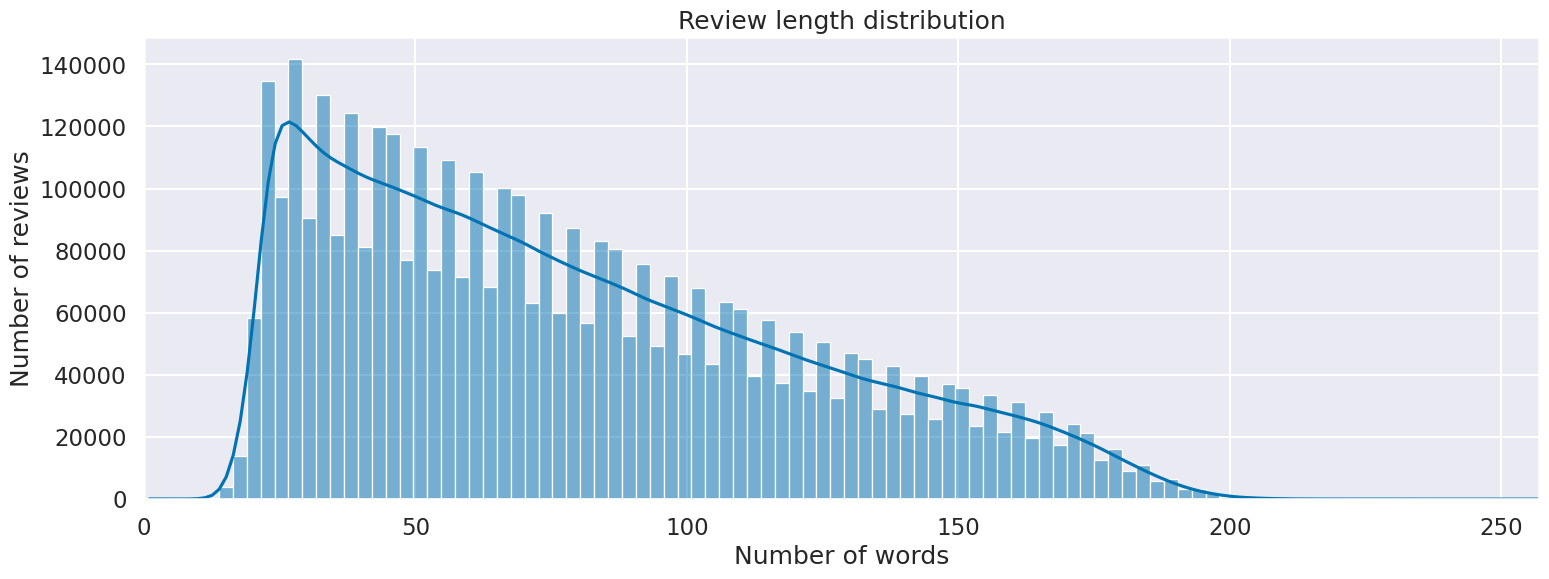

In [6]:
# print some statistics
print(f"Number of reviews: {len(data):,}")
print(f"Number of negative reviews: {len(data[data['rating'] == 1]):,}")
print(f"Number of positive reviews: {len(data[data['rating'] == 0]):,}")

review_lengths = [len(review.split()) for review in data['review'].astype(str)]

# print the longest review in words
print(f"Longest review in words: {max(review_lengths)}")

# print the 99th percentile of review lengths
print(f"99th percentile of review lengths: {np.percentile(review_lengths, 99)}")

# graph the number of words in each review
sns.set_style('darkgrid')
sns.set_context('talk')
sns.set_palette('colorblind')

plt.figure(figsize=(18, 6))

sns.histplot(review_lengths, bins=100, kde=True)

plt.title('Review length distribution')
plt.xlabel('Number of words')
plt.ylabel('Number of reviews')
plt.xlim(0, 257)

plt.show()

In order to get a better sense of the data and make more informed decisions about data processign and model hyperparameters some information about the dataset as a whole is calulated. This dataset has an equal number of positive and negative reviews, making the classes balenced. Notably, the longest and review is 257 words and 99% of all reviews are less then 181 words long. The full distribution can be seen in the graph above.

In [7]:
X = data['review'].astype(str).values
y = data['rating'].values

In [8]:
NUM_TOP_WORDS = None # use entire vocabulary!
MAX_ART_LEN = 200 # maximum and minimum number of words
NUM_CLASSES = 2

if LOAD_FROM_PICKLE:
    with open('../Data/Pickle/reviews_tokenized.pickle', 'rb') as handle:
        X, word_index = pickle.load(handle)
        NUM_TOP_WORDS = len(word_index) if NUM_TOP_WORDS==None else NUM_TOP_WORDS
        top_words = min((len(word_index), NUM_TOP_WORDS))

    print('Loaded tokenized X from pickle')
else:
    tokenizer = Tokenizer(num_words=NUM_TOP_WORDS)
    tokenizer.fit_on_texts(X)

    sequences = tokenizer.texts_to_sequences(X)

    word_index = tokenizer.word_index
    NUM_TOP_WORDS = len(word_index) if NUM_TOP_WORDS==None else NUM_TOP_WORDS
    top_words = min((len(word_index),NUM_TOP_WORDS))

    X = pad_sequences(sequences, maxlen=MAX_ART_LEN)

    # save as pickle
    with open('../Data/Pickle/reviews_tokenized.pickle', 'wb') as handle:
        pickle.dump((X, word_index), handle, protocol=pickle.HIGHEST_PROTOCOL)

y_ohe = keras.utils.to_categorical(y, num_classes=2)

print(f"Found {len(word_index):,} unique tokens. Distilled to {top_words:,} top words.")

Loaded tokenized X from pickle
Found 1,177,501 unique tokens. Distilled to 1,177,501 top words.


Here the data is tokenized and the samles are either cut short or padded to be the same length. I selected a length of 200 words becasue it is long enough to capture the full review for the vast majority of reviews and short enough so that most reviews do not contain an unreasonable amount of padding. The y data is also one hot encoded.

In [9]:
EMBED_SIZE = 100
# the embed size should match the file you load glove from
embeddings_index = {}
f = open('../Data/GloVe/glove.6B.100d.txt')
# save key/array pairs of the embeddings
#  the key of the dictionary is the word, the array is the embedding
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print(f"Found {len(embeddings_index):,} word vectors.\n")

# now fill in the matrix, using the ordering from the
#  keras word tokenizer from before
found_words = 0
embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be ALL-ZEROS
        embedding_matrix[i] = embedding_vector
        found_words = found_words+1

print(f"Embedding Shape: {embedding_matrix.shape}")
print(f"Total words found: {found_words:,}")
print(f"Percentage: {round(100 * found_words / embedding_matrix.shape[0], 2)}")

Found 400,000 word vectors.

Embedding Shape: (1177502, 100)
Total words found: 189,284
Percentage: 16.08


Here the GloVe word embedidng are loaded and the embedding matrix is created. Words which are found in the GloVe embedding have their corresponding embedding vector copied into the matrix. Words which are not found in the GloVe embedding are set to zero.

In [10]:
X_train, X_test, y_train_ohe, y_test_ohe = train_test_split(X, y_ohe, test_size=0.2, stratify=y)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train_ohe shape: {y_train_ohe.shape}")
print(f"y_test_ohe shape: {y_test_ohe.shape}")

X_train shape: (3200000, 200)
X_test shape: (800000, 200)
y_train_ohe shape: (3200000, 2)
y_test_ohe shape: (800000, 2)


An 80/20 split is used to split the data into training and testing sets and the data is stratified to ensure that the classes are balanced in both sets. As the dataset is 4,000,000 samples an 80/20 split is reasonable because it provides good representation of the data in both sets.

In [11]:
# these three functions are from https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

@tf.autograph.experimental.do_not_convert
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

Above, some metric functions are defined to gather histroy data while the modles run

In [35]:
embedding_layer = Embedding(len(word_index) + 1,
                            EMBED_SIZE,
                            weights=[embedding_matrix],# here is the embedding getting saved
                            input_length=MAX_ART_LEN,
                            trainable=False)

def create_RNN(name, RNN_layer_type, num_units):
    if RNN_layer_type == 'LSTM':
        RNN_layer = LSTM
    elif RNN_layer_type == 'GRU':
        RNN_layer = GRU
    else:
        raise ValueError("RNN_layer_type must be one of 'LSTM' or 'GRU'")

    rnn = Sequential(name=name)
    rnn.add(embedding_layer)
    rnn.add(RNN_layer(num_units, dropout=0.2))
    rnn.add(Dense(NUM_CLASSES, activation='sigmoid'))
    rnn.compile(loss='binary_crossentropy',
                optimizer='adam', 
                metrics=['accuracy', recall_m])

    return rnn

rnn1 = create_RNN('RNN-LSTM-25', 'LSTM', 25)
rnn2 = create_RNN('RNN-LSTM-50', 'LSTM', 50)
rnn3 = create_RNN('RNN-GRU-25', 'GRU', 25)
rnn4 = create_RNN('RNN-GRU-50', 'GRU', 50)

models = [rnn1, rnn2, rnn3, rnn4]

for model in models:
    print(model.summary())

Model: "RNN-LSTM-25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 200, 100)          117750200 
                                                                 
 lstm_2 (LSTM)               (None, 25)                12600     
                                                                 
 dense_4 (Dense)             (None, 2)                 52        
                                                                 
Total params: 117,762,852
Trainable params: 12,652
Non-trainable params: 117,750,200
_________________________________________________________________
None
Model: "RNN-LSTM-50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 200, 100)          117750200 
                                                                 
 lstm_3 (L

Four different models are created, two LSTM and two GRU models. All four models contain a single RNN layer of their respective type with either 25 or 50 nodes. Every model shares the same GloVe embedding layer that has training turned off.

In [36]:
LOAD_STORED_MODELS = True

if LOAD_STORED_MODELS:
    for model in models:
        # load model
        model.load_weights(f"Models/Lab7/{model.name}.h5")
        #load history
        with open(f"Models/Lab7/{model.name}.pkl", 'rb') as file_pi:
            model.history = pickle.load(file_pi)

        print(f"Model {model.name} loaded")
else:
    for model in models:
        start = time.time()

        history = model.fit(X_train, y_train_ohe, validation_data=(X_test, y_test_ohe), epochs=75, batch_size=2048, verbose=0)

        print(f"Model {model.name} took {round(time.time() - start, 2)} seconds to train")

        # Save model
        model.save_weights(f"Models/Lab7/{model.name}.h5")
        # save history
        with open(f"Models/Lab7/{model.name}.pkl", 'wb') as f:
            pickle.dump(history.history, f)

        print(f"Model {model.name} saved")


Model RNN-LSTM-25 loaded
Model RNN-LSTM-50 loaded
Model RNN-GRU-25 loaded
Model RNN-GRU-50 loaded


Here the models are trained and saved. Although it can no longer be seen, all four models took a cumlative of 9 hours to train. Both of the models with 50 nodes took longer to train than than their 25 node counterparts.

In [37]:
def plot_history(history, name):
    # plot f1 score, loss, and accuracy for training and validation together
    plt.figure(figsize=(20, 5))

    plt.subplot(1,2,1)
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.ylabel('Loss')
    plt.xlabel('epochs')
    plt.title('Loss')
    plt.legend(['Train', 'Test'], loc='best')

    plt.subplot(1,2,2)
    plt.plot(history['recall_m'])
    plt.plot(history['val_recall_m'])
    plt.ylabel('Recall')
    plt.xlabel('epochs')
    plt.title('Recall')
    plt.legend(['Train', 'Test'], loc='best')

    # set the title for the whole figure
    plt.suptitle(name, fontsize=16)

    plt.show()

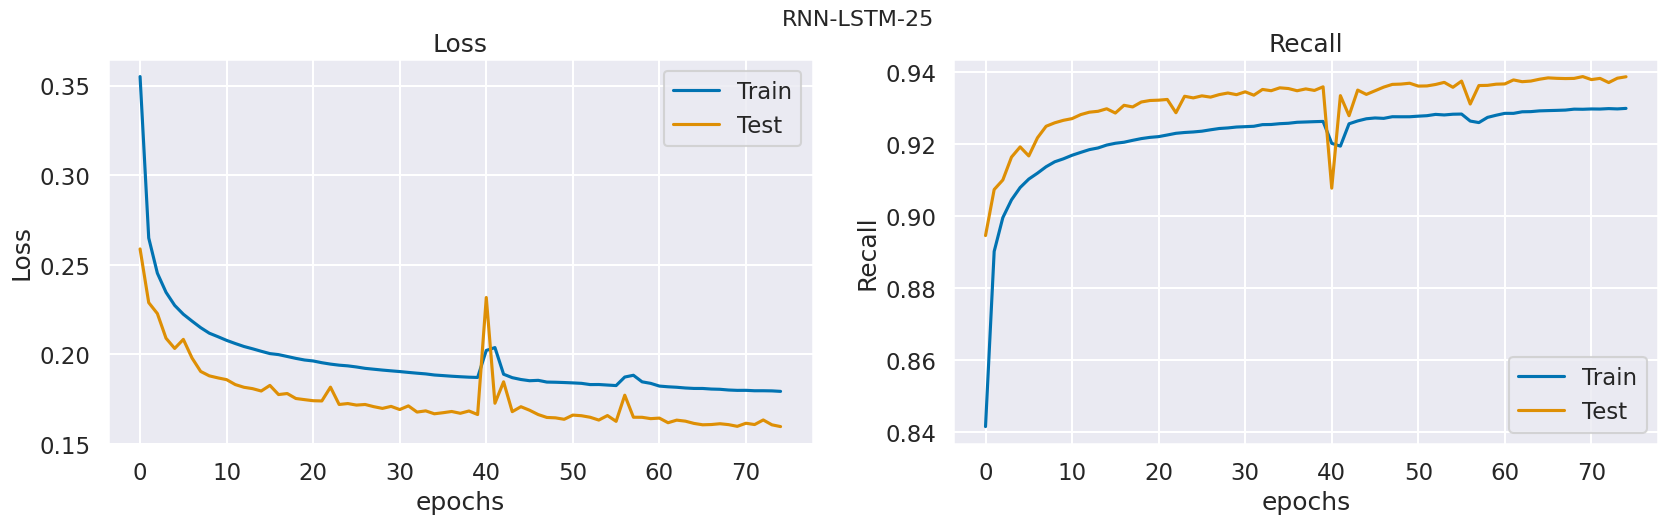

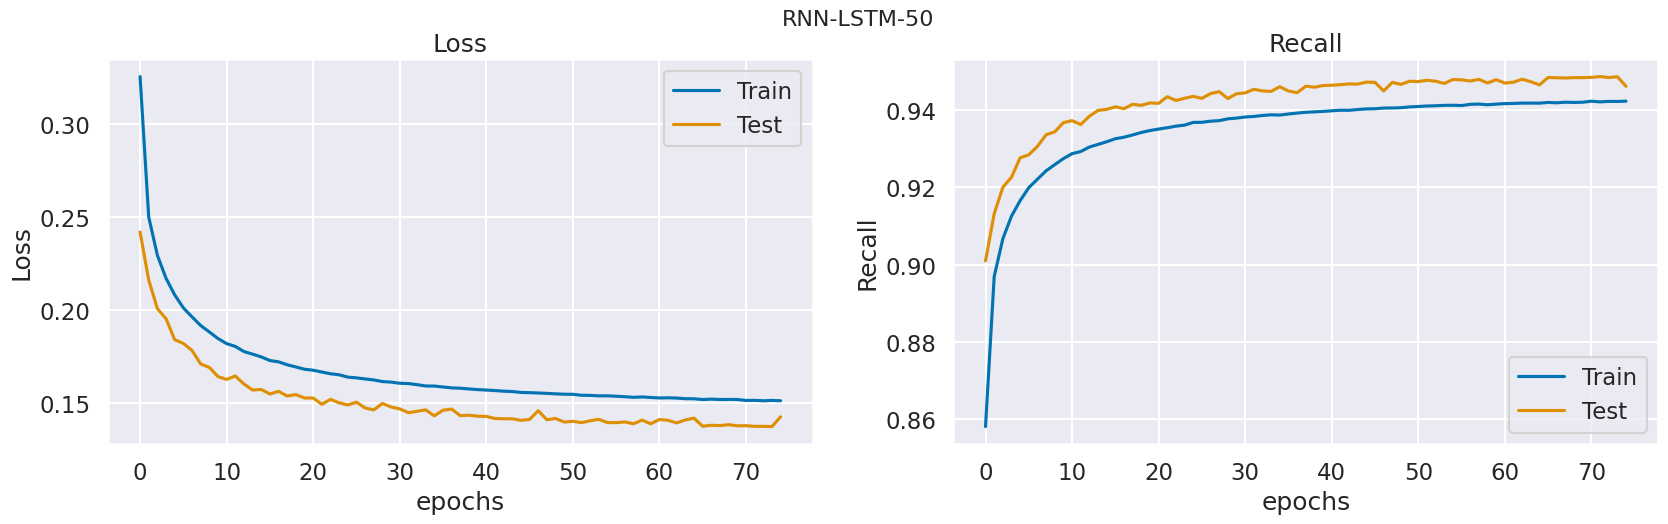

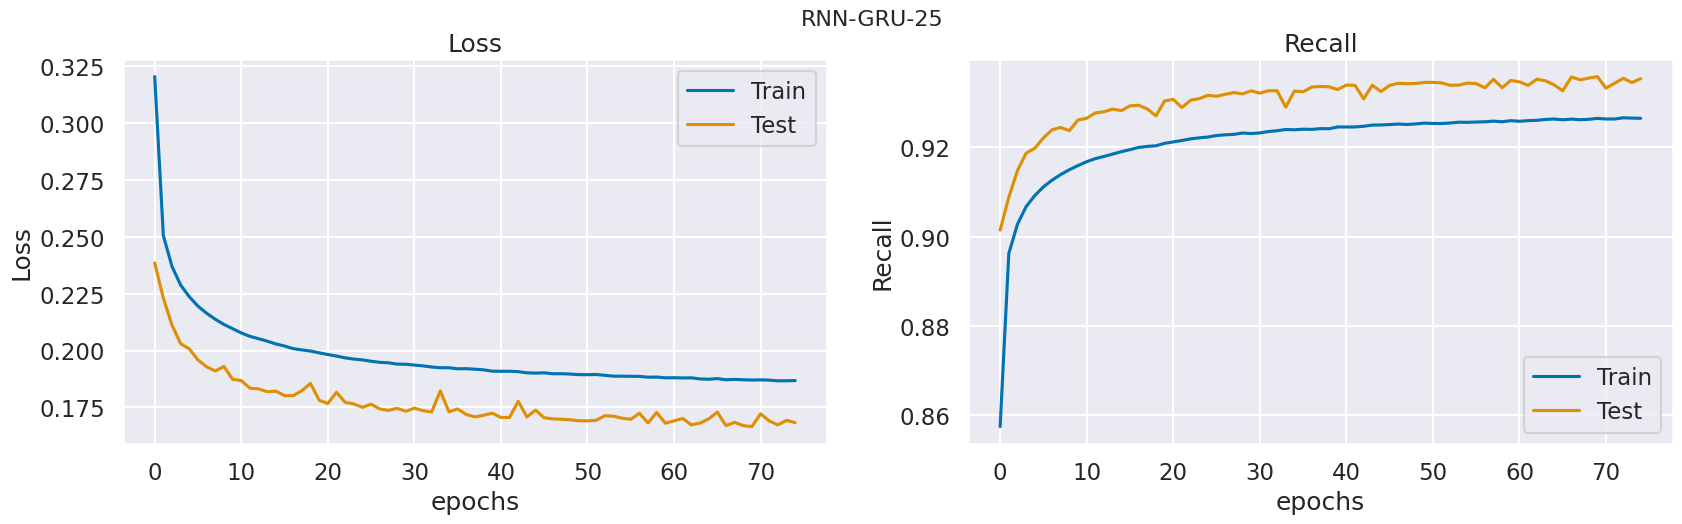

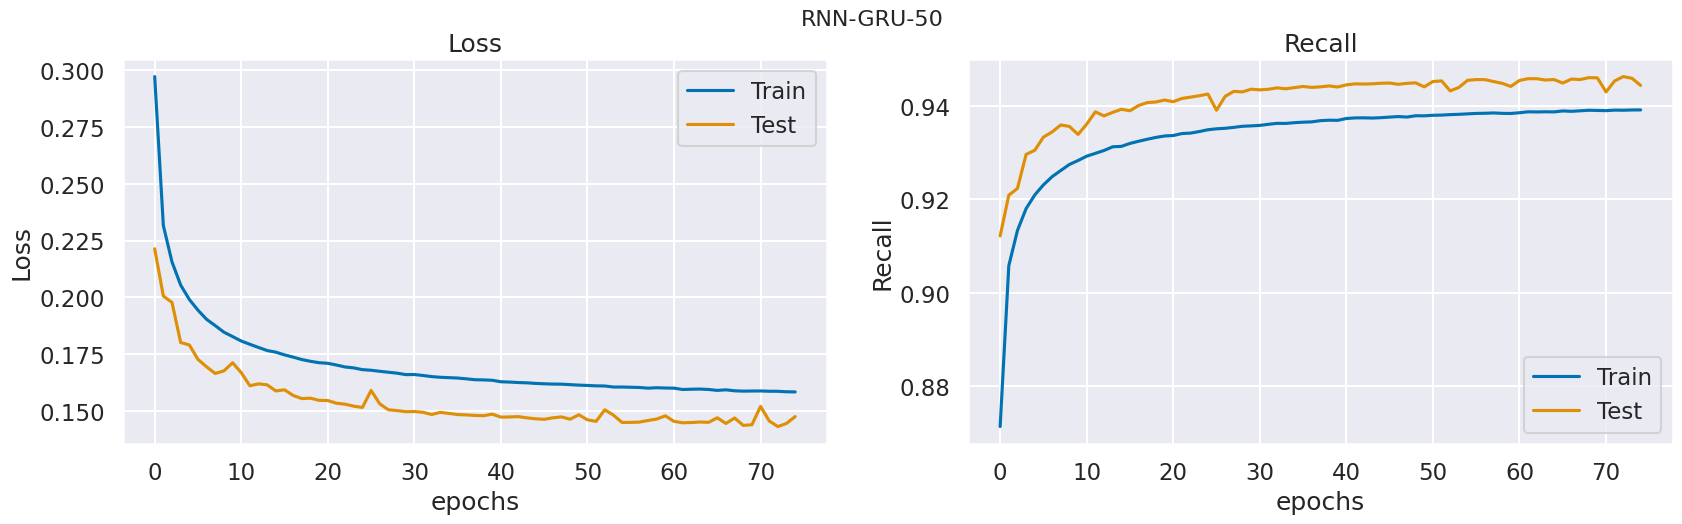

In [38]:
# plot history for all models
for model in models:
    plot_history(model.history, model.name)

As can be seen above all 4 models converged and had signifigant gains in their recall scores. Near the end of their training, all four models had their test recall scores fluctuating slightly as the training recall scores setteled out.

In [39]:
def mcnemar_test(y_test, yhat1, yhat2, name1, name2):
    # create a bitmasks for each of the above
    model1_correct = np.equal(y_test, yhat1)
    model2_correct = np.equal(y_test, yhat2)

    both_correct = np.logical_and(model1_correct, model2_correct)
    both_wrong = np.logical_and(np.logical_not(model1_correct), np.logical_not(model2_correct))
    model1_correct_model2_wrong = np.logical_and(model1_correct, np.logical_not(model2_correct))
    model2_correct_model1_wrong = np.logical_and(model2_correct, np.logical_not(model1_correct))

    # create the contingency table
    table = np.array([[np.sum(both_correct), np.sum(model1_correct_model2_wrong)], [np.sum(model2_correct_model1_wrong), np.sum(both_wrong)]])
    
    # calculate the mcnemar test
    result = mcnemar(table, exact=True)
    # calculate the significance
    p = result.pvalue
    # interpret the p-value
    alpha = 0.05

    p_str = str(round(p, 5)).ljust(7, '0')

    if p > alpha:
        print(f'p-value = {p_str} > {alpha} (alpha). Fail to reject the null hypothesis (H0), that there is no signifigant difference between {name1} and {name2}')
    else:
        print(f'p-value = {p_str} < {alpha} (alpha). Reject H0. There is a significant difference between {name1} and {name2}')


A function for the McNemar test is defined here. This test is used to determine if the difference between two models is statistically significant.

In [40]:
yhat_probs = []

for model in models:
    print(f"Predicting for {model.name}")
    yhat_probs.append(model.predict(X_test))

yhat_predicitions = []
for yhat_prob in yhat_probs:
    yhat_predicitions.append(np.argmax(yhat_prob, axis=1).flatten())

y_test_max = y_test_ohe.argmax(axis=1)
y_test_max = y_test_max.flatten()

Predicting for RNN-LSTM-25
25000/25000 [==============================] - 143s 6ms/step
Predicting for RNN-LSTM-50
25000/25000 [==============================] - 151s 6ms/step
Predicting for RNN-GRU-25
25000/25000 [==============================] - 150s 6ms/step
Predicting for RNN-GRU-50
25000/25000 [==============================] - 183s 7ms/step


In [41]:
# run mcnemar test for each unique pair of models
for i in range(len(models)):
    for j in range(i+1, len(models)):
        print(f'Mcnemar test for {models[i].name} and {models[j].name}:')
        mcnemar_test(y_test_max, yhat_predicitions[i], yhat_predicitions[j], models[i].name, models[j].name)

Mcnemar test for RNN-LSTM-25 and RNN-LSTM-50:
p-value = 0.00000 < 0.05 (alpha). Reject H0. There is a significant difference between RNN-LSTM-25 and RNN-LSTM-50
Mcnemar test for RNN-LSTM-25 and RNN-GRU-25:
p-value = 0.00000 < 0.05 (alpha). Reject H0. There is a significant difference between RNN-LSTM-25 and RNN-GRU-25
Mcnemar test for RNN-LSTM-25 and RNN-GRU-50:
p-value = 0.00000 < 0.05 (alpha). Reject H0. There is a significant difference between RNN-LSTM-25 and RNN-GRU-50
Mcnemar test for RNN-LSTM-50 and RNN-GRU-25:
p-value = 0.00000 < 0.05 (alpha). Reject H0. There is a significant difference between RNN-LSTM-50 and RNN-GRU-25
Mcnemar test for RNN-LSTM-50 and RNN-GRU-50:
p-value = 0.00000 < 0.05 (alpha). Reject H0. There is a significant difference between RNN-LSTM-50 and RNN-GRU-50
Mcnemar test for RNN-GRU-25 and RNN-GRU-50:
p-value = 0.00000 < 0.05 (alpha). Reject H0. There is a significant difference between RNN-GRU-25 and RNN-GRU-50


The McNemar test is used on every pair of models and it shows that there is a statistically significant difference between every model. This allows us to select the best model based on recall score.

In [48]:
# print the recall for each model
for i in range(len(models)):
    print(f'Recall for {models[i].name:12}: {round(mt.recall_score(max_as_int, preds_as_int[i]), 5):.5f}')

Recall for RNN-LSTM-25 : 0.94266
Recall for RNN-LSTM-50 : 0.93110
Recall for RNN-GRU-25  : 0.94886
Recall for RNN-GRU-50  : 0.93077


The best model was the RNN-GRU-25 as it had the highest recall score. Both of the models with 25 nodes performed better than their 50 node counterparts. This is likely due to the fact that the 50 node models were overfitting the data. Additionally, it is worth noting that varience in the recall score durring training that can be seen in the graphs may by large enough to change which model scored the highest depending on which epoch training ended on. Ultimately, all four models performed very well and had very similar recall scores.